# Library

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !pip install protobuf==3.20


In [ ]:
# !pip install tensorflow==2.8.0

In [ ]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    LearningRateScheduler
)
import sklearn.metrics
import torch
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

# Data Gathering

In [ ]:
# Path ke folder dataset (Using Google Colab)
#input_dir = "/content/drive/MyDrive/New_Model/Datasets"

# Path ke folder dataset (Using VSCode)
input_dir = "EcoCraft dataset"

# Membaca nama folder yang ada
columns = [folder for folder in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, folder))]

# Buat daftar untuk menyimpan semua file dan kategori biner
merged_unique = []
allColumn_lists = []

# Loop melalui setiap kategori
for category in columns:
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        # Ambil semua file .jpg dalam kategori ini
        category_files = [f for f in os.listdir(category_path) if f.endswith(('.png', '.jpeg', '.jpg')) and
                          os.path.isfile(os.path.join(category_path, f))]

        if category_files:  # Hanya tambahkan jika ada file
            # Tambahkan file ke merged_unique
            merged_unique.extend(category_files)
            # Tambahkan daftar file kategori ke allColumn_lists
            allColumn_lists.append(category_files)
        else:
            print(f"Warning: Folder '{category}' kosong atau tidak memiliki file .jpg.")
            allColumn_lists.append([])  # Tambahkan daftar kosong jika folder kosong
    else:
        print(f"Error: Folder '{category}' tidak ditemukan di '{input_dir}'.")
        allColumn_lists.append([])  # Tambahkan daftar kosong jika folder tidak ditemukan

# Hilangkan duplikasi di merged_unique
merged_unique = list(set(merged_unique))

# Buat kolom biner untuk setiap kategori
all_bin_columns = []
for column in allColumn_lists:
    bin_column = []
    for merged_file in merged_unique:
        if merged_file in column:
            bin_column.append(1)  # Cocok
        else:
            bin_column.append(0)  # Tidak cocok
    all_bin_columns.append(bin_column)

# Cek apakah jumlah kategori cocok
if len(columns) != len(all_bin_columns):
    print("Error: Jumlah kolom tidak cocok dengan jumlah kategori!")
    print(f"columns: {len(columns)}, all_bin_columns: {len(all_bin_columns)}")
    exit()

# Buat DataFrame untuk memetakan file dan kategori biner
imageMap_train = pd.DataFrame({'Filenames': merged_unique})
for i, category in enumerate(columns):
    imageMap_train[category] = all_bin_columns[i]

# Atur agar semua kolom terlihat saat dicetak
pd.set_option('display.max_columns', None)

# Tampilkan DataFrame hasil
print(imageMap_train.head(10))

                                           Filenames  Bohlam  Botol Plastik  \
0                              IMG20230408134532.jpg       0              0   
1                                berantakan (54).jpg       0              0   
2                                         R_2438.jpg       0              0   
3                                         R_2917.jpg       0              0   
4                                       Sendok17.jpg       0              0   
5                             single-piece (113).jpg       0              0   
6                               with-hanger (32).jpg       0              0   
7                                       00000380.jpg       0              0   
8  images294_jpg.rf.7f8e8792f1dc55bdf438299f8b581...       0              0   
9                                             91.jpg       0              0   

   Garpu  Gelas Plastik  Hanger  Kain  Kaleng  Kardus  Kertas  Kotak susu  \
0      0              0       0     0       0       0

In [ ]:
# Dictionary untuk menyimpan jumlah sampel per kategori
category_counts = defaultdict(int)

# Loop melalui setiap kategori di dalam folder
for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):  # Pastikan itu folder
        # Hitung jumlah file JPG dalam kategori ini
        num_files = len([f for f in os.listdir(category_path) if f.endswith(('.png', '.jpeg', '.jpg')) and os.path.isfile(os.path.join(category_path, f))])
        category_counts[category] += num_files

# Hitung total sampel dan jumlah unik
total_samples = sum(category_counts.values())
unique_samples = len(category_counts)

# Cetak hasil
print("Number of Samples:")
print("-------------------------")
for category, count in category_counts.items():
    print(f"{category} = {count}")
print("--------------------------")
print(f"Total number of samples = {total_samples}")
print(f"Total number of Unique samples = {unique_samples}")

Number of Samples:
-------------------------
Bohlam = 200
Botol Plastik = 272
Garpu = 176
Gelas Plastik = 264
Hanger = 238
Kain = 277
Kaleng = 253
Kardus = 259
Kertas = 293
Kotak susu = 221
Sendok = 185
Tutup Botol = 242
--------------------------
Total number of samples = 2880
Total number of Unique samples = 12


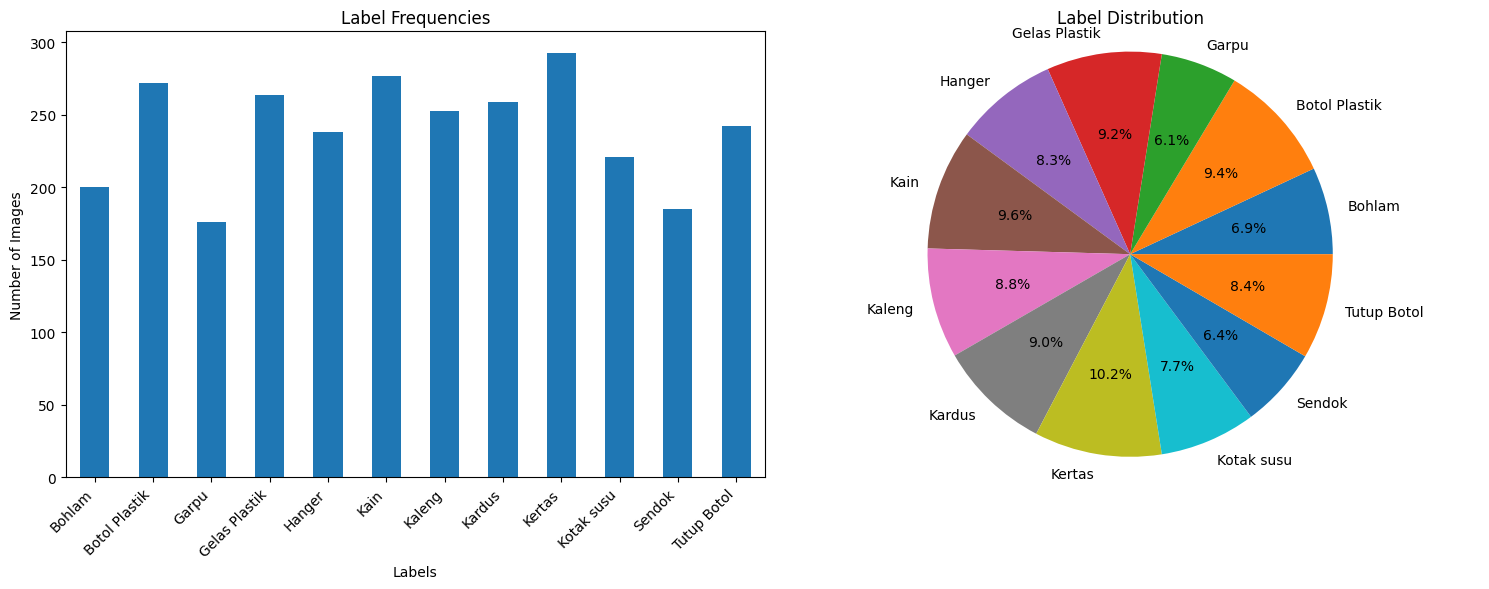

In [ ]:
"""Visualize label distribution in the dataset"""

# Get label columns (excluding 'Image_Name')
label_columns = imageMap_train.columns.tolist()[1:]

# Calculate label frequencies
label_frequencies = imageMap_train[label_columns].sum()

# Plotting
plt.figure(figsize=(15, 6))

# Bar plot of label frequencies
plt.subplot(1, 2, 1)
label_frequencies.plot(kind='bar')
plt.title('Label Frequencies')
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Pie chart of label distribution
plt.subplot(1, 2, 2)
plt.pie(label_frequencies, labels=label_frequencies.index, autopct='%1.1f%%')
plt.title('Label Distribution')
plt.axis('equal')
plt.tight_layout()

plt.show()

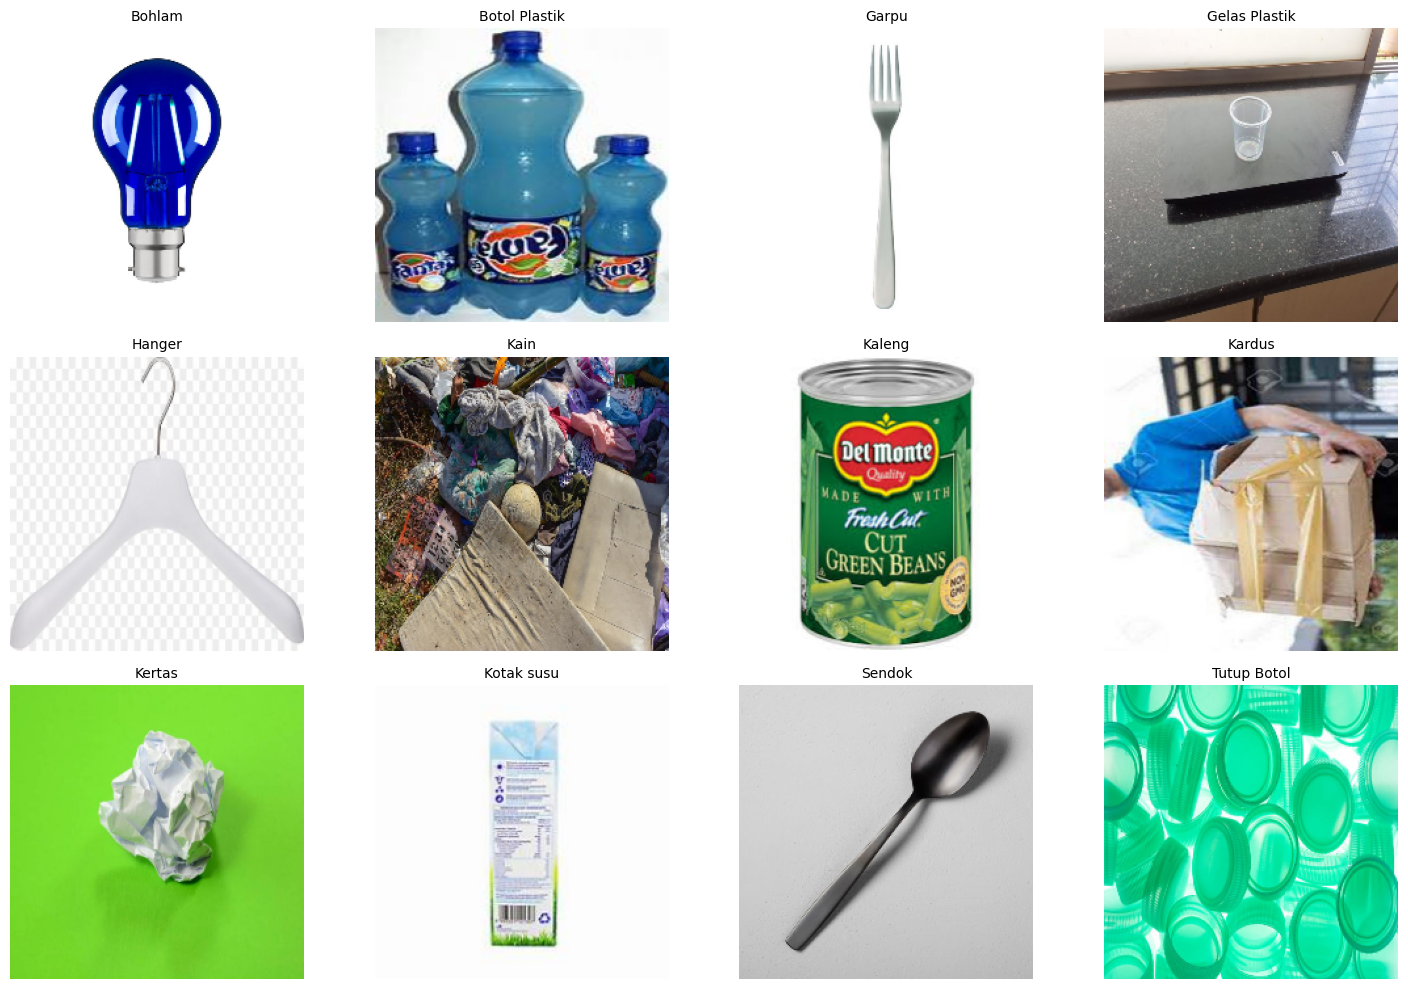

In [ ]:
# Get all category folders
categories = [folder for folder in os.listdir(input_dir)
              if os.path.isdir(os.path.join(input_dir, folder))]

# Create visualization
plt.figure(figsize=(15, 10))

# Calculate grid dimensions
rows = 3
cols = 4

# Iterate through categories
for idx, category in enumerate(categories):
    folder_path = os.path.join(input_dir, category)

    # Get all image files in this folder
    all_images = [os.path.join(folder_path, file) for file in os.listdir(folder_path)
                  if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    # Select the first image (or continue if no images)
    if len(all_images) > 0:
        selected_image = all_images[9]

        # Read image with OpenCV (converts to RGB)
        try:
            img = cv2.imread(selected_image)
            if img is None:
                print(f"Warning: Could not read image {selected_image}")
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Resize image to ensure consistency
            img_resized = cv2.resize(img_rgb, (224, 224))

            # Create subplot
            plt.subplot(rows, cols, idx + 1)
            plt.imshow(img_resized)
            plt.title(category, fontsize=10)
            plt.axis('off')
        except Exception as e:
            print(f"Error processing {selected_image}: {e}")
    else:
        print(f"Warning: No images found in category {category}")

# Adjust layout and display
plt.tight_layout()

# Show the plot (optional, depending on your environment)
plt.show()

# Split Data

In [ ]:
# Main workflow (Using Google Colab)
# output_dataset_dir = "/content/drive/MyDrive/New_Model/Organized_Dataset"
# model_output_dir = "/content/drive/MyDrive/New_Model/Waste_Detection_Model"
# input_dir="/content/drive/MyDrive/New_Model/Dataset"

# Main Workflow (Using VSCode)
output_dataset_dir = "Organized_Dataset"
model_output_dir = "Waste_Detection_Model"

# Ensure directories exist
os.makedirs(output_dataset_dir, exist_ok=True)
os.makedirs(model_output_dir, exist_ok=True)

In [ ]:
# Create train, val, and test directories
subsets = ['train', 'val', 'test']
for subset in subsets:
    os.makedirs(os.path.join(output_dataset_dir, subset), exist_ok=True)

# Iterate through categories
for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if not os.path.isdir(category_path):
        continue  # Skip non-directory files

    # List all images in the category
    all_images = [f for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if len(all_images) == 0:
        print(f"No images found in category {category}. Skipping...")
        continue  # Skip categories with no images

    # Split into train, val, test
    train_images, temp_images = train_test_split(all_images, train_size=0.8, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Move files into corresponding directories
    for subset, images in zip(subsets, [train_images, val_images, test_images]):
        subset_dir = os.path.join(output_dataset_dir, subset, category)
        os.makedirs(subset_dir, exist_ok=True)
        for img in images:
            src = os.path.join(category_path, img)
            dst = os.path.join(subset_dir, img)

            # Debug print statements
            print(f"Attempting to copy:")
            print(f"Source: {src}")
            print(f"Destination: {dst}")

            # Add checks before copying
            if not os.path.exists(src):
                print(f"ERROR: Source file does not exist: {src}")
                continue

            try:
                shutil.copy2(src, dst)
            except Exception as e:
                print(f"Error copying {img}: {e}")

print("Dataset reorganization attempt completed!")

Attempting to copy:
Source: dataset\Bohlam\Ligth_bulb_169_jpg.rf.1a04b37962e97e2c53d52c83cbab304d.jpg
Destination: Organized_Dataset\train\Bohlam\Ligth_bulb_169_jpg.rf.1a04b37962e97e2c53d52c83cbab304d.jpg
Attempting to copy:
Source: dataset\Bohlam\Ligth_bulb_98_jpg.rf.4cfffb1ce14bc3ad953ed2b7e683e7b4.jpg
Destination: Organized_Dataset\train\Bohlam\Ligth_bulb_98_jpg.rf.4cfffb1ce14bc3ad953ed2b7e683e7b4.jpg
Attempting to copy:
Source: dataset\Bohlam\Ligth_bulb_131_jpg.rf.dc3c947dbb7d0b5f1dca4008277b0e2d.jpg
Destination: Organized_Dataset\train\Bohlam\Ligth_bulb_131_jpg.rf.dc3c947dbb7d0b5f1dca4008277b0e2d.jpg
Attempting to copy:
Source: dataset\Bohlam\Ligth_bulb_119_jpg.rf.2261a364d117801e779b4ab1a1cb6586.jpg
Destination: Organized_Dataset\train\Bohlam\Ligth_bulb_119_jpg.rf.2261a364d117801e779b4ab1a1cb6586.jpg
Attempting to copy:
Source: dataset\Bohlam\Ligth_bulb_28_jpg.rf.d120c46e231b40bb8f20a638b24e82a3.jpg
Destination: Organized_Dataset\train\Bohlam\Ligth_bulb_28_jpg.rf.d120c46e231b40bb

# Data Generator

In [ ]:
def create_data_generators(train_dir, val_dir, input_shape=(224, 224, 3), batch_size=32):
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        fill_mode='nearest'
    )

    # Simple rescaling for validation
    val_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators
    def class_generator(datagen, directory, is_training=True, **kwargs):
        generator = datagen.flow_from_directory(
            directory,
            target_size=input_shape[:2],
            batch_size=batch_size,
            class_mode='categorical',  # Ensures one-hot encoding for multi-class
            shuffle=is_training
        )
        return generator

    # Create custom generators
    train_generator = class_generator(train_datagen, train_dir, is_training=True)
    val_generator = class_generator(val_datagen, val_dir, is_training=False)

    # Count number of classes
    num_classes = len(train_generator.class_indices)

    # Print class indices for reference
    print("Class Indices:", train_generator.class_indices)
    print("Number of Classes:", num_classes)

    return train_generator, val_generator, num_classes

In [ ]:
# Prepare data generators (Using Google Colab)
# train_dir = os.path.join(output_dataset_dir, '/content/drive/MyDrive/New_Model/Organized_Dataset/train')
# val_dir = os.path.join(output_dataset_dir, '/content/drive/MyDrive/New_Model/Organized_Dataset/val')
# test_dir = os.path.join(output_dataset_dir, '/content/drive/MyDrive/New_Model/Organized_Dataset/test')

# Prepare data generators (Using VSCode)
train_dir = os.path.join(output_dataset_dir, 'train')
val_dir = os.path.join(output_dataset_dir, 'val')
test_dir = os.path.join(output_dataset_dir, 'test')

# Create data generators
train_generator, val_generator, num_classes = create_data_generators(
    train_dir,
    val_dir
)

Found 2299 images belonging to 12 classes.
Found 287 images belonging to 12 classes.
Class Indices: {'Bohlam': 0, 'Botol Plastik': 1, 'Garpu': 2, 'Gelas Plastik': 3, 'Hanger': 4, 'Kain': 5, 'Kaleng': 6, 'Kardus': 7, 'Kertas': 8, 'Kotak susu': 9, 'Sendok': 10, 'Tutup Botol': 11}
Number of Classes: 12


# Model

In [ ]:
def build_model(input_shape=(224, 224, 3), num_classes=12):
    # Load pre-trained model
    base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    # Add custom classification head
    x = base_model.output
    x = Conv2D(64, (3, 3),activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)

    # Output layer with sigmoid activation
    output_layer = Dense(num_classes, activation='softmax', name='waste_classification')(x)

    # Create final model
    model = Model(inputs=base_model.input, outputs=output_layer)

    return model

In [ ]:
# Build model
model = build_model(num_classes=12)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# Contoh penggunaan dengan model
model.compile(optimizer=Adam(learning_rate=1e-4), loss=loss_fn, metrics=['accuracy'])


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv1 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn1            │ (None, 111, 111,  │        128 │ stem_conv1[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_conv_1_s… │ (None, 111, 111,  │        352 │ activation[0][0]  │
│ (Conv2D)            │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reduction_bn_1_ste… │ (None, 111, 111,  │         44 │ reduction_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 111, 111,  │          0 │ reduction_bn_1_s… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 111, 111,  │          0 │ stem_bn1[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 115, 115,  │          0 │ activation_1[0][… │
│ (ZeroPadding2D)     │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_p… │ (None, 117, 117,  │          0 │ activation_3[0][… │
│ (ZeroPadding2D)     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │        396 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_r… │ (None, 56, 56,    │      1,920 │ separable_conv_1… │
│ (SeparableConv2D)   │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_1_b… │ (None, 56, 56,    │         44 │ separable_conv_1… │
│ (BatchNormalizatio… │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 56, 56,    │          0 │ separable_conv_1… │
│ (Activation)        │ 11)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv_2_r… │ (None, 56, 56,    │        396 │ activation_2[0][

 Total params: 5,045,728 (19.25 MB)

 Trainable params: 776,012 (2.96 MB)

 Non-trainable params: 4,269,716 (16.29 MB)

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr  # Keep learning rate same in the first 10 epochs
    else:
        return float(lr * tf.math.exp(-0.1))  # Apply exponential decay

In [ ]:
def train_model(model, train_generator, val_generator, train_dir, val_dir, epochs=50):
    # Hitung jumlah sampel di setiap direktori
    def count_samples(directory):
        total_samples = 0
        for root, dirs, files in os.walk(directory):
            # Hitung file gambar (dengan ekstensi umum)
            image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            total_samples += len(image_files)
        return total_samples

    train_samples = count_samples(train_dir)
    val_samples = count_samples(val_dir)

    batch_size = 32  # Sesuaikan dengan batch_size di generator
    steps_per_epoch = max(1, train_samples // batch_size)
    validation_steps = max(1, val_samples // batch_size)

    print(f"Total training samples: {train_samples}")
    print(f"Total validation samples: {val_samples}")
    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Validation steps: {validation_steps}")

    # Learning rate reducer
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    # Early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    # Model checkpoint
    model_checkpoint = ModelCheckpoint(
        filepath=os.path.join(model_output_dir, 'best_model.keras'),
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )

    lr_scheduler = LearningRateScheduler(scheduler)
    # Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=[lr_scheduler, reduce_lr, early_stop, model_checkpoint]
    )

    return history

In [ ]:
# Train model
history = train_model(
    model, train_generator, val_generator, train_dir, val_dir
)

Total training samples: 2299
Total validation samples: 287
Steps per epoch: 71
Validation steps: 8


c:\Users\WatsonNick\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3544 - loss: 2.1334
Epoch 1: val_loss improved from inf to 0.47601, saving model to Waste_Detection_Model\best_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.3572 - loss: 2.1264 - val_accuracy: 0.8711 - val_loss: 0.4760 - learning_rate: 1.0000e-04
Epoch 2/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 24s 349ms/step - accuracy: 0.8125 - loss: 0.5684

c:\Users\WatsonNick\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 2: val_loss did not improve from 0.47601
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8125 - loss: 0.5684 - val_accuracy: 0.8710 - val_loss: 0.7125 - learning_rate: 1.0000e-04
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.8246 - loss: 0.5739
Epoch 3: val_loss improved from 0.47601 to 0.29622, saving model to Waste_Detection_Model\best_model.keras
71/71 ━━━━━━━━━━━━━━━━━━━━ 65s 910ms/step - accuracy: 0.8250 - loss: 0.5726 - val_accuracy: 0.8945 - val_loss: 0.2962 - learning_rate: 1.0000e-04
Epoch 4/50
 1/71 ━━━━━━━━━━━━━━━━━━━━ 27s 395ms/step - accuracy: 0.9062 - loss: 0.2726
Epoch 4: val_loss did not improve from 0.29622
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9062 - loss: 0.2726 - val_accuracy: 0.9355 - val_loss: 0.4009 - learning_rate: 1.0000e-04
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.8857 - loss: 0.3559
Epoch 5: val_loss did not improve from 0.29622
71/71 ━━━━━━━━━━━━━━━━━━━━ 56s 784ms/step - accuracy: 0.885

# Model Evaluation

In [ ]:
input_shape=(224, 224, 3)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Prepare labels
y_true = np.zeros((len(test_generator.filenames), len(test_generator.class_indices)))
for i, filename in enumerate(test_generator.filenames):
    # Extract directory name (category) from filepath
    category = os.path.basename(os.path.dirname(filename))
    # Set corresponding index to 1
    y_true[i, test_generator.class_indices[category]] = 1

# Evaluate model
test_loss, test_accuracy = model.evaluate(
    test_generator,
    verbose=1
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
predictions = model.predict(test_generator)

# Apply threshold to predictions
y_pred = (predictions > 0.91).astype(int)

Found 294 images belonging to 12 classes.
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 814ms/step - accuracy: 0.9573 - loss: 0.1582
Test Loss: 0.1806
Test Accuracy: 0.9388
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step 


In [ ]:
# Compute metrics
hamming_loss = sklearn.metrics.hamming_loss(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred, average='samples')
recall = sklearn.metrics.recall_score(y_true, y_pred, average='samples')
f1_score = sklearn.metrics.f1_score(y_true, y_pred, average='samples')

print("\nMetrics:")
print(f"Hamming Loss: {hamming_loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Classification Report
class_names = list(test_generator.class_indices.keys())
cr = sklearn.metrics.classification_report(
    y_true,
    y_pred,
    target_names=class_names
)
print("\nClassification Report:")
print(cr)


Metrics:
Hamming Loss: 0.0150
Precision: 0.8299
Recall: 0.8299
F1 Score: 0.8299

Classification Report:
               precision    recall  f1-score   support

       Bohlam       1.00      0.95      0.97        20
Botol Plastik       1.00      0.82      0.90        28
        Garpu       1.00      0.83      0.91        18
Gelas Plastik       1.00      0.93      0.96        27
       Hanger       1.00      0.96      0.98        24
         Kain       1.00      0.86      0.92        28
       Kaleng       0.96      1.00      0.98        26
       Kardus       0.95      0.81      0.88        26
       Kertas       0.94      0.53      0.68        30
   Kotak susu       1.00      0.70      0.82        23
       Sendok       1.00      0.68      0.81        19
  Tutup Botol       1.00      0.92      0.96        25

    micro avg       0.99      0.83      0.90       294
    macro avg       0.99      0.83      0.90       294
 weighted avg       0.99      0.83      0.90       294
  samples avg

c:\Users\WatsonNick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\WatsonNick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


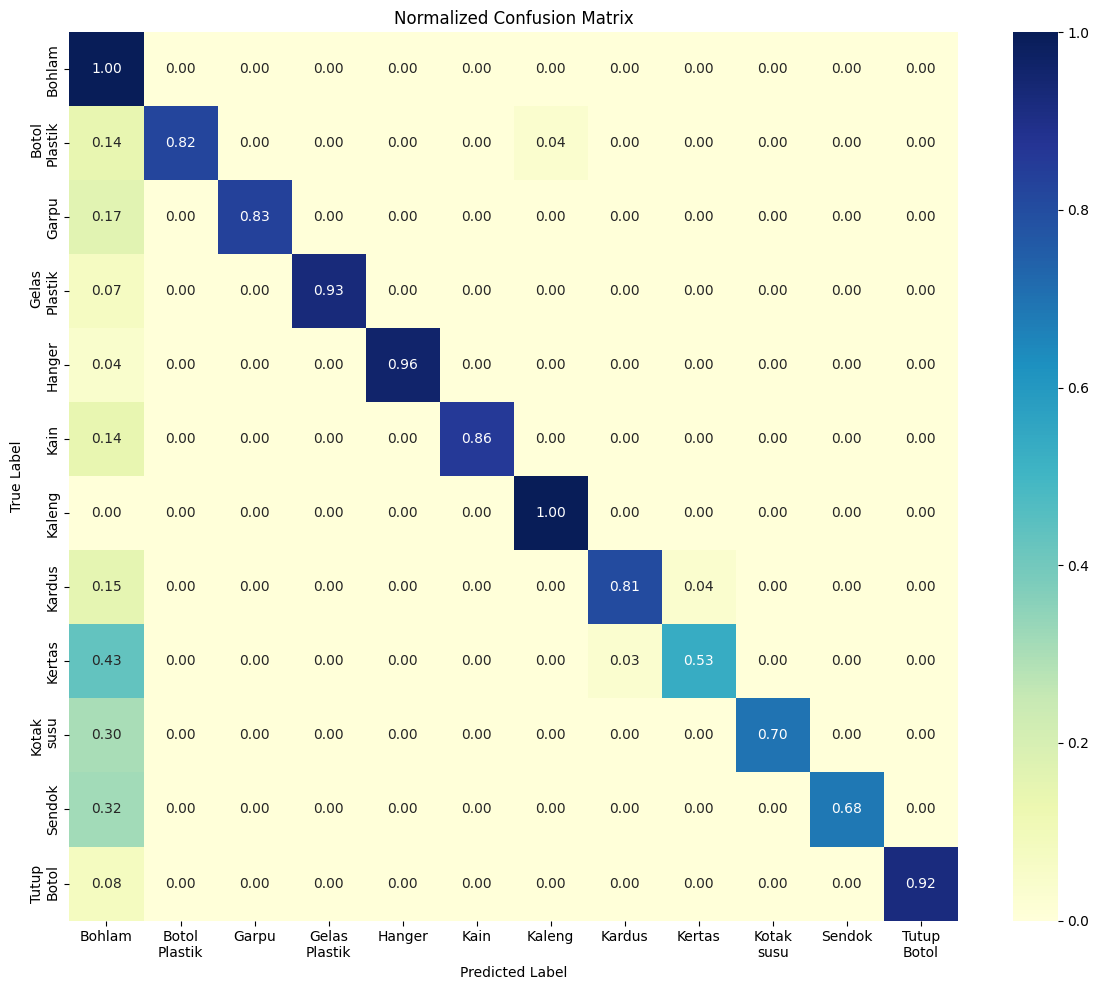

In [ ]:
# Confusion Matrix Visualization
plt.figure(figsize=(12, 10))  # Sesuaikan ukuran gambar jika perlu
cm = sklearn.metrics.confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Buat label horizontal dan bagi 2 baris untuk nama kelas dengan dua kata
xtick_labels = ['\n'.join(label.split()) for label in class_names]
ytick_labels = ['\n'.join(label.split()) for label in class_names]

# Create heatmap using seaborn
sns.heatmap(
    cm_normalized,
    annot=True,  # Show numeric values
    cmap='YlGnBu',  # Color palette
    fmt='.2f',  # Format of the annotations
    xticklabels=xtick_labels,
    yticklabels=ytick_labels
)

plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.xticks(rotation=0)  # Memastikan label x tetap horizontal
plt.show()

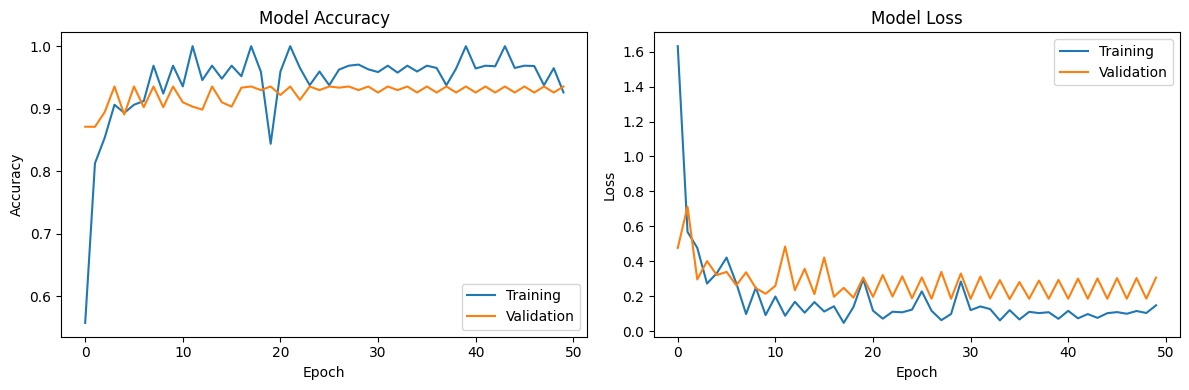

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save model
model_save_path = os.path.join(model_output_dir, 'waste_detector.h5')
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to Waste_Detection_Model\waste_detector.h5


In [ ]:
def visualize_model_prediction(image, true_labels, pred_probs, class_names):

    # Create figure with more space
    plt.figure(figsize=(15, 6))

    # Display image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Input Image')
    plt.axis('off')

    # Display prediction results
    plt.subplot(1, 2, 2)

    # Identify the index of the highest probability
    highest_prob_index = np.argmax(pred_probs)

    # Prepare prediction labels
    predicted_labels = (pred_probs).astype(int)

    # Create bar plot of probabilities
    bars = plt.bar(class_names, pred_probs, color='skyblue')
    plt.title('Prediction Probabilities')
    plt.xlabel('Classes')
    plt.ylabel('Probability')
    plt.xticks(rotation=45, ha='right')

    # Color and annotate bars based on probability and highlight the highest
    for i, (prob, pred_label, true_label) in enumerate(zip(pred_probs, predicted_labels, true_labels)):
        # Highlight the bar with the highest probability in green
        if i == highest_prob_index:
            color = 'green'
        else:
            color = 'lightcoral' if pred_label == 0 else 'orange'  # Default colors

        bars[i].set_color(color)

        # Annotate with probability and true/pred status
        status = '✓' if pred_label == true_label else '✗'
        plt.text(i, prob, f'{prob:.2f} {status}',
                 ha='center', va='bottom',
                 color='black', fontweight='bold')

    # Add legend to explain color coding
    plt.legend([
        plt.Rectangle((0,0),1,1, color='green', alpha=0.5),
        plt.Rectangle((0,0),1,1, color='lightcoral', alpha=0.5),
        plt.Rectangle((0,0),1,1, color='orange', alpha=0.5)
    ], [
        'Highest Probability',
        'Correct Negative',
        'Misclassification'
    ], loc='upper right')

    plt.tight_layout()
    plt.show()

In [ ]:
# ImageDataGenerator for Testing Data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 294 images belonging to 12 classes.


In [ ]:
# Pilih indeks acak dari generator
random_idx = np.random.randint(len(test_generator))

# Ambil batch gambar dan label dari generator
test_batch, test_labels_batch = test_generator[random_idx]

# Choose 1 random image dan labels from batch
image_idx = np.random.randint(len(test_batch))
test_image = test_batch[image_idx]
true_label = test_labels_batch[image_idx]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
Predicted probabilities: [2.1221766e-05 4.1150788e-06 8.1744402e-05 5.7492731e-04 1.2147051e-04
 9.9210301e-03 1.8429750e-04 1.3751686e-03 9.8760682e-01 6.1137260e-05
 3.8444668e-05 9.6359472e-06]


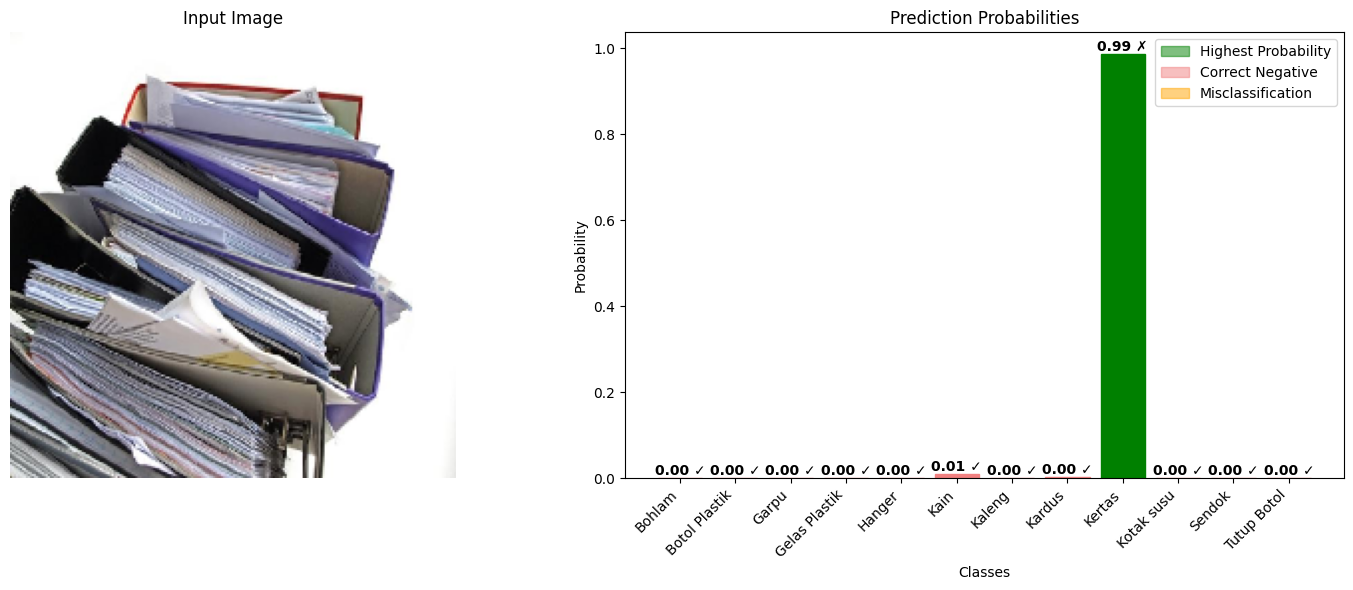

In [ ]:
# Predict probabilities
pred_probs = model.predict(np.expand_dims(test_image, axis=0))[0]

# Display the result
print("Predicted probabilities:", pred_probs)

# Visualize Prediction result
visualize_model_prediction(
    test_image,
    true_label,
    pred_probs,
    list(test_generator.class_indices.keys())
)

# Test Upload Image

In [ ]:
# Load the image
from PIL import Image
test_image_path = r"C:\Users\WatsonNick\Bangkit EcoCraft\download (1).jpeg"
image = Image.open(test_image_path)

image_resized = image.resize((224, 224))
image_array = np.array(image_resized) / 255.0  # Normalize pixel values to [0, 1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Predicted probabilities: [2.6012547e-03 3.4338606e-03 2.7839362e-04 2.2234309e-03 5.6349474e-04
 1.3688797e-02 1.0841105e-02 9.2252652e-04 9.6778013e-04 2.4855265e-04
 7.8027588e-03 9.5642811e-01]


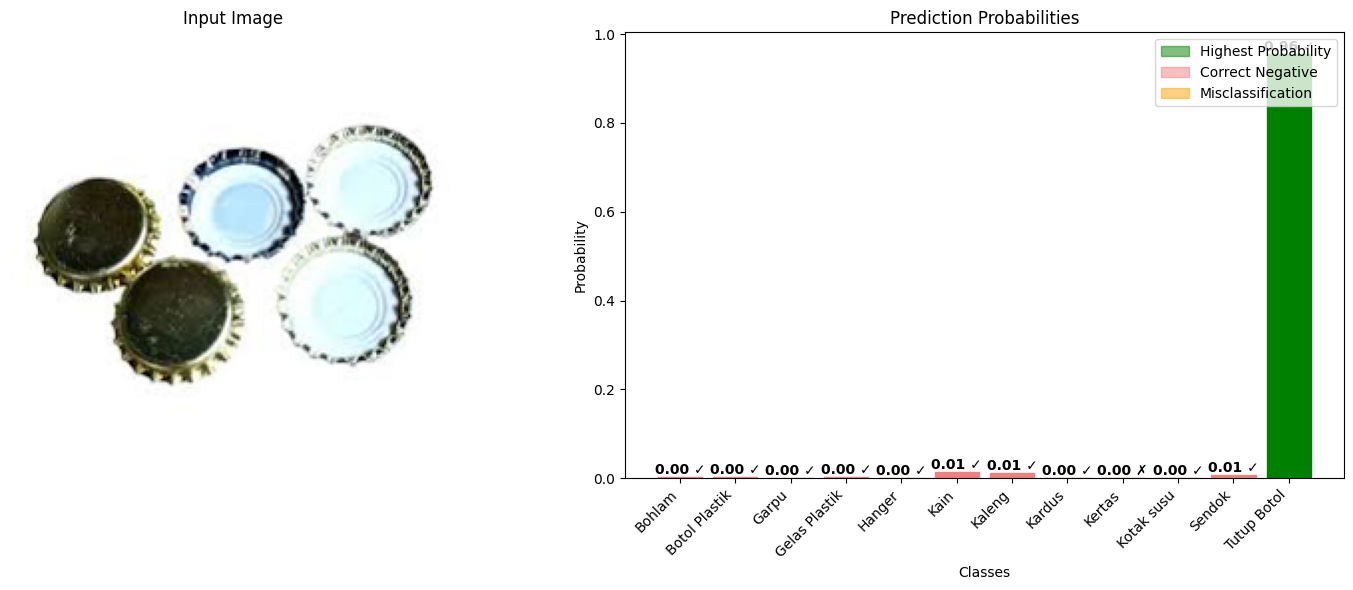

In [ ]:
image_input = np.expand_dims(image_array, axis=0)  # Shape: (1, 224, 224, 3)

# Predict probabilities
pred_probs = model.predict(image_input)[0]

# Display the result
print("Predicted probabilities:", pred_probs)

# Visualisasikan hasil prediksi
visualize_model_prediction(
    image_resized,
    true_label,
    pred_probs,
    list(test_generator.class_indices.keys())
)